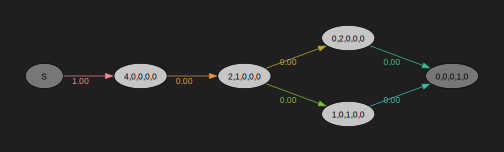

In [1]:

import numpy as np

from phasic import Graph, set_theme

import jax.numpy as jnp

set_theme('dark')

def coalescent(state, nr_samples=None):
    if not state.size:
        ipv = [[[nr_samples]+[0]*nr_samples, 1, []]]
        return ipv
    else:
        transitions = []
        for i in range(nr_samples):
            for j in range(i, nr_samples):            
                same = int(i == j)
                if same and state[i] < 2:
                    continue
                if not same and (state[i] < 1 or state[j] < 1):
                    continue 
                new = state.copy()
                new[i] -= 1
                new[j] -= 1
                new[i+j+1] += 1
                transitions.append([new, 0.0, [state[i]*(state[j]-same)/(1+same)]])
        return transitions


true_theta = np.array([7])  
nr_samples = 4
graph = Graph(callback=coalescent, parameterized=True, nr_samples=nr_samples) # should check using the graph hash if a trace of the graph is cached or available online
graph.plot()

## Some artifical data simulated from the model

In [2]:
nr_observations = 1000
_graph = Graph(callback=coalescent, parameterized=True, nr_samples=nr_samples) # should check using the graph hash if a trace of the graph is cached or available online
_graph.update_parameterized_weights(true_theta)
observed_data = _graph.sample(nr_observations)

INFO: loaded elimination trace from cache (aa79bdbdb986a207dccce0fcb7d6ba52383ec6b42df5a00feb709e72e31b2baf): 29 operations, 6 vertices
INFO: loaded elimination trace from cache (aa79bdbdb986a207dccce0fcb7d6ba52383ec6b42df5a00feb709e72e31b2baf)


(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': 'ExponentialDecayStepSize'}, xlabel='Iteration', ylabel='Step Size'>)

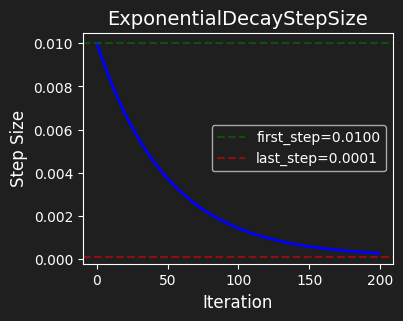

In [18]:

def uninformative_prior(phi):
    """Uninformative prior: φ ~ N(0, 10^2) - very wide"""
    mu = 0.0
    sigma = 10.0
    return -0.5 * jnp.sum(((phi - mu) / sigma)**2)

from phasic import SVGD, ExponentialDecayStepSize, ExponentialDecayRegularization, ExponentialCDFRegularization

step_schedule = ExponentialDecayStepSize(first_step=0.01, last_step=0.0001, tau=50.0)
step_schedule.plot(200)

(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': 'ExponentialDecayStepSize'}, xlabel='Iteration', ylabel='Step Size'>)

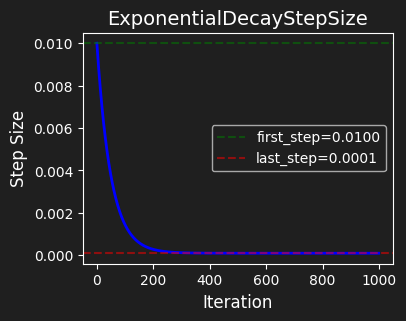

In [21]:
reg_schedule = ExponentialDecayRegularization(first_reg=10.0, last_reg=1.0, tau=50.0)
step_schedule.plot()

In [ ]:
params = dict(
            observed_data=observed_data,
            bandwidth='median', # bandwidth='local_adaptive',
            theta_dim=len(true_theta),
            prior=uninformative_prior, 
            n_particles=20,
            n_iterations=200,
            learning_rate=step_schedule, 
            seed=42,
            verbose=False,
            discrete=False, 
            regularization=reg_schedule, 
            nr_moments=2,
)

In [27]:

svgd = graph.svgd(**params)

TypeError: sub got incompatible shapes for broadcasting: (2,), (3,).

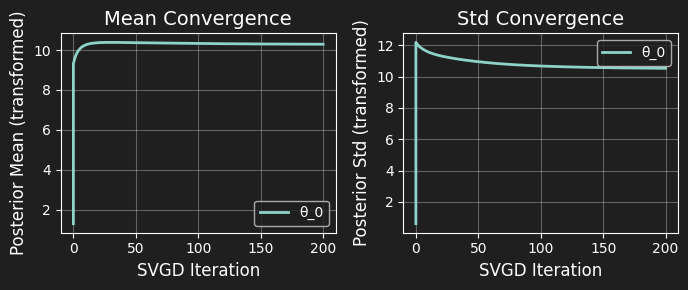

In [24]:
svgd.plot_convergence() ;

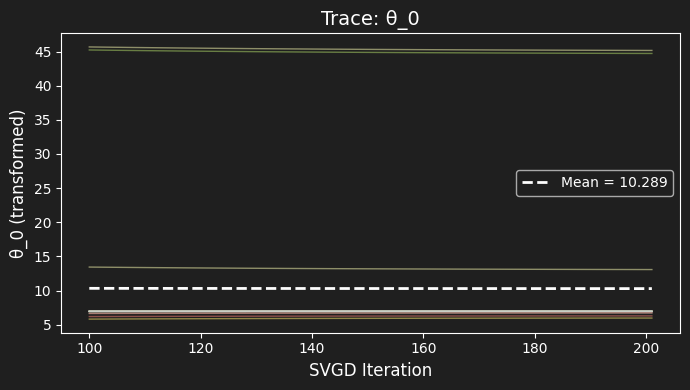

In [25]:
svgd.plot_trace(skip=100) ;

In [6]:
model_pdf = Graph.pmf_from_graph(graph)
svgd = SVGD(model_pdf, **params)
svgd.fit(return_history=True)
results = svgd.get_results()
print(results['theta_mean'], results['theta_std'])


[6.85982646] [0.27471283]


In [7]:

# # without recreating the graph, pmf_and_moments_from_graph do not produce any trace
graph = Graph(callback=coalescent, parameterized=True, nr_samples=nr_samples)

model_pdf = Graph.pmf_and_moments_from_graph(graph)
svgd = SVGD(model_pdf, **params)
svgd.fit_regularized(nr_moments=2, regularization=1.0, return_history=True)
results = svgd.get_results()
print(results['theta_mean'], results['theta_std'])

KeyboardInterrupt: 

In [ ]:
%%monitor

model_pdf = Graph.pmf_from_graph(graph)
svgd = SVGD(model_pdf, **params)
svgd.fit(return_history=True) ;

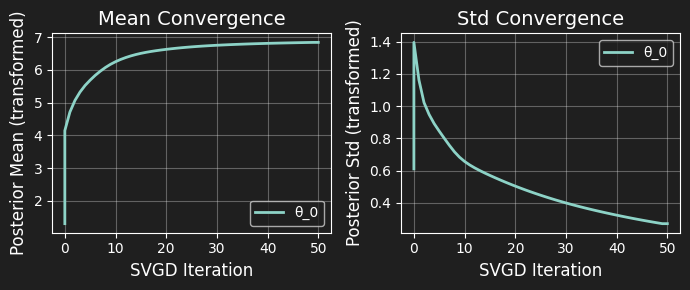

In [ ]:
svgd.plot_convergence() ;

INFO: loaded elimination trace from cache (aa79bdbdb986a207dccce0fcb7d6ba52383ec6b42df5a00feb709e72e31b2baf): 29 operations, 6 vertices
INFO: loaded elimination trace from cache (aa79bdbdb986a207dccce0fcb7d6ba52383ec6b42df5a00feb709e72e31b2baf)


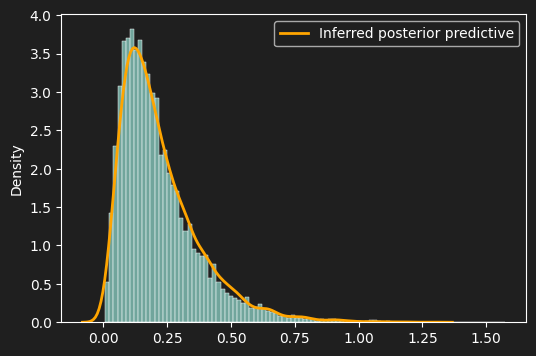

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
graph.update_parameterized_weights(svgd.particles.mean(axis=0))
sns.histplot(observed_data, kde=False, stat='density')
sns.kdeplot(graph.sample(5000), color='orange', label='Inferred posterior predictive', linewidth=2)
plt.legend() ;

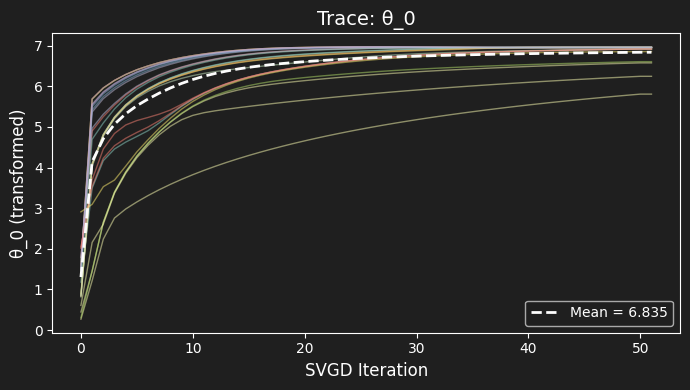

In [ ]:
fig, axes = svgd.plot_trace()

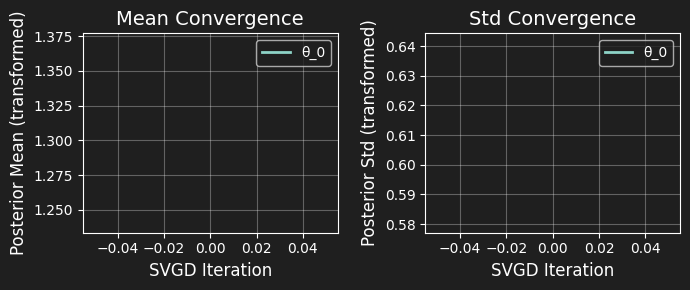

In [ ]:
model_pdf = Graph.pmf_and_moments_from_graph(graph)
svgd = SVGD(model_pdf, **params)
svgd.fit_regularized(nr_moments=2, regularization=1.0, return_history=True)
svgd.plot_convergence() ;

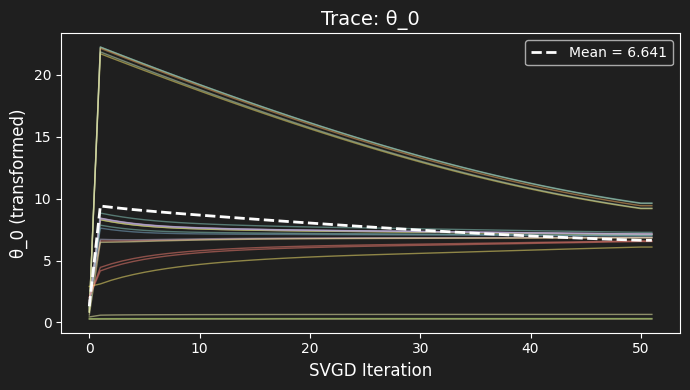

In [ ]:

# SOMEHOW WE NEED TO RESET THE GRAPH TO INITIAL STATE HERE TO MAKE fit_regularized WORK. NOT SURE WHY. THIS IS NOT A PROBLEM WITH fit().
graph = Graph(callback=coalescent, parameterized=True, nr_samples=nr_samples) # should check using the graph hash if a trace of the graph is cached or available online

model_pdf = Graph.pmf_and_moments_from_graph(graph)
svgd = SVGD(model_pdf, **params)

svgd.fit_regularized(nr_moments=2, regularization=0.2, return_history=True)

#svgd.analyze_trace()
fig, axes = svgd.plot_trace()

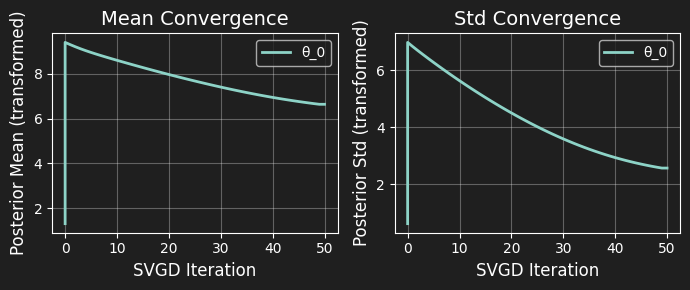

In [ ]:
svgd.plot_convergence() ;